In [44]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt



In [84]:
class ExponentialRegression:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.results = {}
        self.scaled_pollutants = None
        self.scaled_X_pollutants = {}
        self.y = None

    def exponential_model(self, x, a, b):
        """Exponential function to fit the data."""
        return a * np.exp(b * x)

    def fit_scaler(self, data, pollutants, target_column):
        """
        Fit the scaler and scale only the specified pollutants as independent variables.
    
        Parameters:
        - data: pandas DataFrame containing the dataset.
        - pollutants: List of column names to be used as predictors.
        - target_column: Column name to be used as the target variable.
        """
        # Ensure pollutants and target column exist in the data
        missing_cols = set(pollutants + [target_column]) - set(data.columns)
        if missing_cols:
            raise ValueError(f"The following columns are missing from the dataset: {missing_cols}")

        # Subset the data to only include specified pollutants and target
        numeric_data = data[pollutants + [target_column]]
    
        # Scale the pollutants
        self.scaled_pollutants = self.scaler.fit_transform(numeric_data[pollutants])
        self.y = numeric_data[target_column].values

        # Add small constant to y if necessary
        if (self.y <= 0).any():
            self.y += 1e-6

        # Store scaled pollutants in a dictionary
        for i, col in enumerate(pollutants):
            self.scaled_X_pollutants[col] = self.scaled_pollutants[:, i]


    def correlation(self):
        # Calculate and display correlation coefficients
        correlations = {}
        for pollutant in pollutants:
            correlation = data['pm2_5'].corr(data[pollutant])
            correlations[pollutant] = correlation
            print(f"Correlation between PM2.5 and {pollutant.upper()}: {correlation:.2f}")

        # Visualize correlations with scatter plots
        for pollutant in pollutants:
            plt.scatter(data[pollutant], data['pm2_5'], alpha=0.7, label=f'{pollutant.upper()}')
            plt.title(f'PM2.5 vs {pollutant.upper()}')
            plt.xlabel(f'{pollutant.upper()} Concentration')
            plt.ylabel('PM2.5 Concentration')
            plt.show()

    def fit(self):
        """Fit exponential regression for all pollutants."""
        for pollutant, scaled_x in self.scaled_X_pollutants.items():
            try:
                params, _ = curve_fit(self.exponential_model, scaled_x, self.y, maxfev=10000)
                y_pred = self.exponential_model(scaled_x, *params)
                r2 = r2_score(self.y, y_pred)

                self.results[pollutant] = {
                    "params": params,
                    "r2": r2
                }
                print(f"Exponential Regression for {pollutant.upper()}: R² = {r2:.6f}")
            except RuntimeError:
                print(f"Exponential fit failed for {pollutant.upper()}")
                self.results[pollutant] = None

    def calculate_mse(self):
        """Calculate MSE for all pollutants and identify the best one."""
        mse_results = {}
        for pollutant, scaled_x in self.scaled_X_pollutants.items():
            if pollutant in self.results and self.results[pollutant]:
                params = self.results[pollutant]["params"]
                y_pred = self.exponential_model(scaled_x, *params)
                mse = mean_squared_error(self.y, y_pred)
                mse_results[pollutant] = mse
                print(f"MSE for PM2.5 vs {pollutant.upper()}: {mse:.2f}")

        if mse_results:
            best_pollutant = min(mse_results, key=mse_results.get)
            print(f"The pollutant with the strongest exponential relationship to PM2.5 is {best_pollutant.upper()}")

            # Plot MSE results
            plt.figure(figsize=(10, 6))
            plt.bar(mse_results.keys(), mse_results.values(), color=['red', 'green', 'blue', 'orange', 'purple'], alpha=0.8)
            plt.title("MSE for Exponential Regression by Pollutant", fontsize=14)
            plt.ylabel("Mean Squared Error (MSE)", fontsize=12)
            plt.xlabel("Pollutants", fontsize=12)
            plt.grid(axis='y', linestyle='--', alpha=0.3)
            plt.show()

    def plot_fits(self):
        """Plot scatter and fit line for each pollutant."""
        for pollutant, scaled_x in self.scaled_X_pollutants.items():
            if pollutant in self.results and self.results[pollutant]:
                params = self.results[pollutant]["params"]
                x_sorted = np.sort(scaled_x)
                y_pred_sorted = self.exponential_model(x_sorted, *params)

                plt.figure(figsize=(8, 6))
                plt.scatter(scaled_x, self.y, color='blue', alpha=0.6, label='Observed Data')
                plt.plot(x_sorted, y_pred_sorted, color='red', linewidth=2, label='Exponential Fit')
                plt.title(f'Exponential Fit: PM2.5 vs {pollutant.upper()}', fontsize=14)
                plt.xlabel(f'Scaled {pollutant.upper()} Concentration')
                plt.ylabel('PM2.5 Concentration')
                plt.legend()
                plt.grid(alpha=0.3)
                plt.show()
    
    def prediction(self):
        # Get the last observed CO value (scaled and original)
        last_co_original = data['co'].iloc[-1]

        # Create a placeholder array with 6 features (matching the scaler)
        placeholder_means = np.mean(scaled_pollutants, axis=0)  # Mean of scaled pollutants
        last_co_scaled = scaler.transform([[last_co_original] + list(placeholder_means[1:])])[0, 0]  # Include other pollutant means


        # Generate future CO levels starting from the last observed value
        future_co_scaled = np.linspace(last_co_scaled, 1.0, 10).reshape(-1, 1)

        # Create a full array for inverse_transform
        future_scaled_full = np.tile(placeholder_means, (len(future_co_scaled), 1))
        future_scaled_full[:, 0] = future_co_scaled.flatten()

        # Inverse transform to original CO values
        future_co_original = scaler.inverse_transform(future_scaled_full)[:, 0]

        # Predict PM2.5 using the exponential model
        future_pm25 = exponential_model(future_co_scaled.flatten(), a, b)

        # Plot predictions with original CO values
        plt.figure(figsize=(8, 6))
        plt.plot(future_co_original, future_pm25, marker='o', color='red', label='Predicted PM2.5')
        plt.title('Predicted PM2.5 Based on Future CO Levels (Continuous)', fontsize=14)
        plt.xlabel('Original CO Levels (µg/m³)', fontsize=12)
        plt.ylabel('Predicted PM2.5 (µg/m³)', fontsize=12)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

        # Display predictions
        for i, (co, pm25) in enumerate(zip(future_co_original, future_pm25)):
            print(f"Future CO (original): {co:.2f} µg/m³, Predicted PM2.5: {pm25:.2f} µg/m³")


    def sensitivity(self):
        # Compute the sensitivity (rate of change) for PM2.5 with respect to CO
        sensitivity = np.gradient(future_pm25, future_co_original)

        # Plot sensitivity with original CO values
        plt.figure(figsize=(8, 6))
        plt.plot(future_co_original, sensitivity, marker='o', color='blue', label='Sensitivity (ΔPM2.5 / ΔCO)')
        plt.title('Sensitivity of PM2.5 to Changes in CO Levels', fontsize=14)
        plt.xlabel('Original CO Levels (µg/m³)', fontsize=12)
        plt.ylabel('Sensitivity (ΔPM2.5 / ΔCO)', fontsize=12)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()

        # Display sensitivity values
        for co, sens in zip(future_co_original, sensitivity):
            print(f"CO (original): {co:.2f} µg/m³, Sensitivity (ΔPM2.5 / ΔCO): {sens:.2f}")


    def overlay_prediction(self):
        # Sort the original data by CO levels for a clean fit line
        sorted_indices = np.argsort(original_co)  # Get sorted indices
        sorted_co = original_co.iloc[sorted_indices]  # Sort CO levels
        sorted_scaled_co = scaled_X_pollutants['co'][sorted_indices]  # Sort scaled CO levels
        sorted_pm25 = y[sorted_indices]  # Sort PM2.5 values

        # Predict PM2.5 for the sorted CO levels
        sorted_predicted_pm25 = exp_model.exponential_model(sorted_scaled_co, *exp_model.results['co']['params'])

        # Plot the overlay graph
        plt.figure(figsize=(10, 6))
        plt.scatter(original_co, y, color='blue', label='Observed Data', alpha=0.6)
        plt.plot(sorted_co, sorted_predicted_pm25, color='red', label='Exponential Fit', linewidth=2)
        plt.title('Observed PM2.5 vs CO with Exponential Fit', fontsize=14)
        plt.xlabel('CO Levels (µg/m³)', fontsize=12)
        plt.ylabel('PM2.5 Levels (µg/m³)', fontsize=12)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.show()


Correlation between PM2.5 and CO: 0.97
Correlation between PM2.5 and NO: 0.92
Correlation between PM2.5 and NO2: 0.89
Correlation between PM2.5 and O3: -0.44
Correlation between PM2.5 and SO2: 0.48
Correlation between PM2.5 and NH3: 0.67


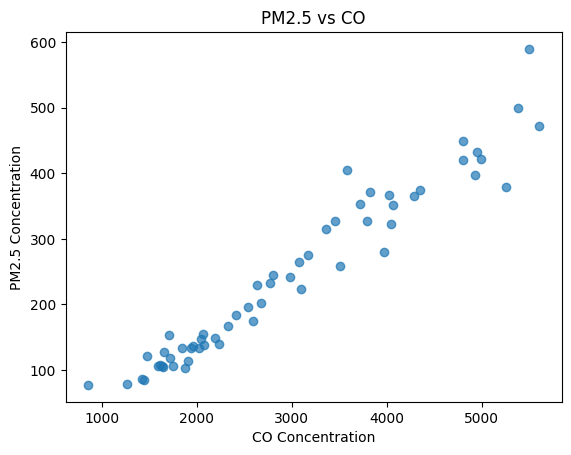

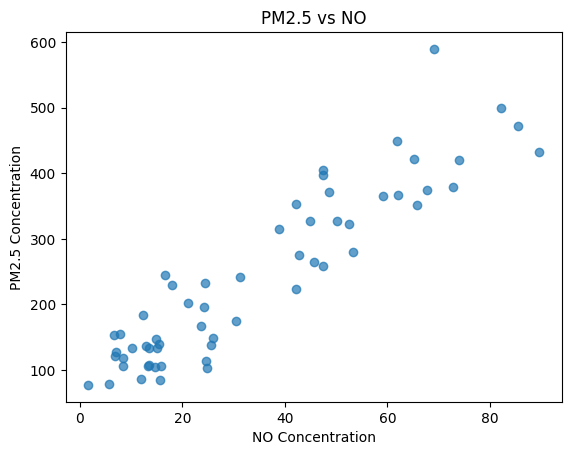

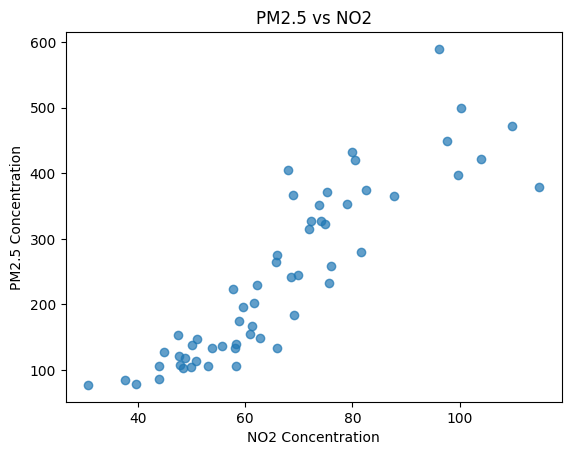

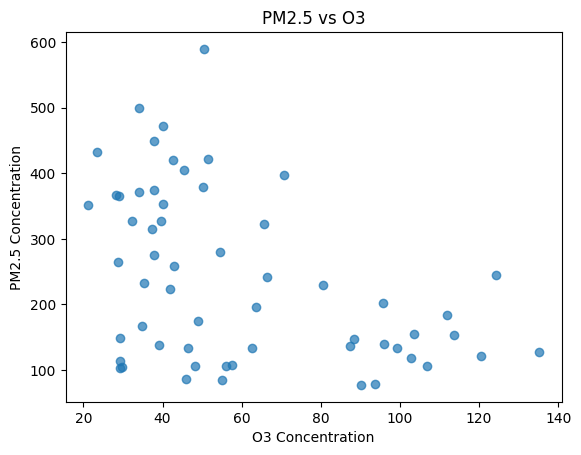

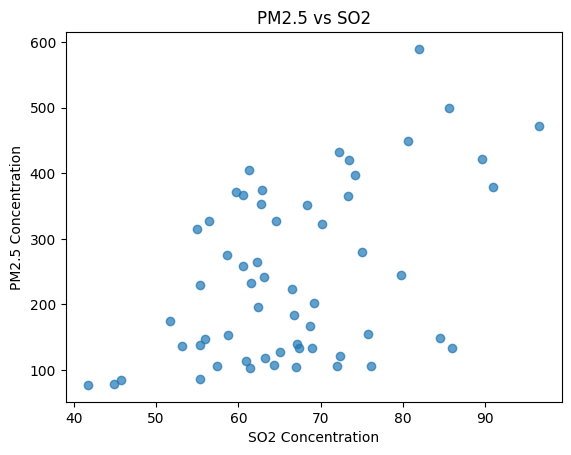

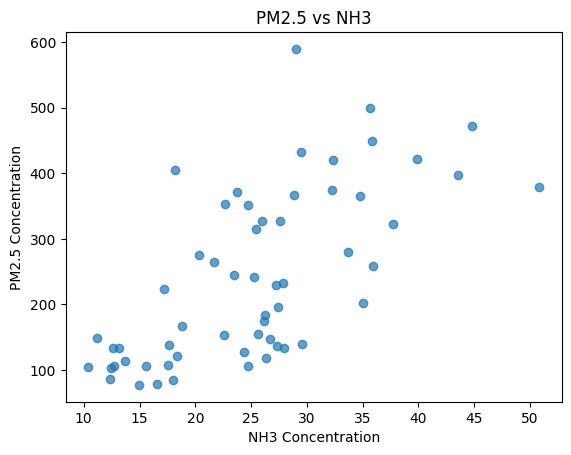

In [86]:
# Pollutants to compare with PM2.5
pollutants = ['co', 'no', 'no2', 'o3', 'so2', 'nh3']

data = pd.read_csv('../Data/biweekly_air_quality_data.csv')

# Initialize the model
exp_model = ExponentialRegression()

# Fit the scaler and prepare data
exp_model.fit_scaler(data, pollutants=pollutants, target_column='pm2_5')

exp_model.correlation()

In [87]:
# Fit the exponential regression model
exp_model.fit()


Exponential Regression for CO: R² = 0.901678
Exponential Regression for NO: R² = 0.791526
Exponential Regression for NO2: R² = 0.699988
Exponential Regression for O3: R² = 0.194487
Exponential Regression for SO2: R² = 0.232432
Exponential Regression for NH3: R² = 0.406552


MSE for PM2.5 vs CO: 1637.43
MSE for PM2.5 vs NO: 3471.87
MSE for PM2.5 vs NO2: 4996.33
MSE for PM2.5 vs O3: 13414.83
MSE for PM2.5 vs SO2: 12782.91
MSE for PM2.5 vs NH3: 9883.16
The pollutant with the strongest exponential relationship to PM2.5 is CO


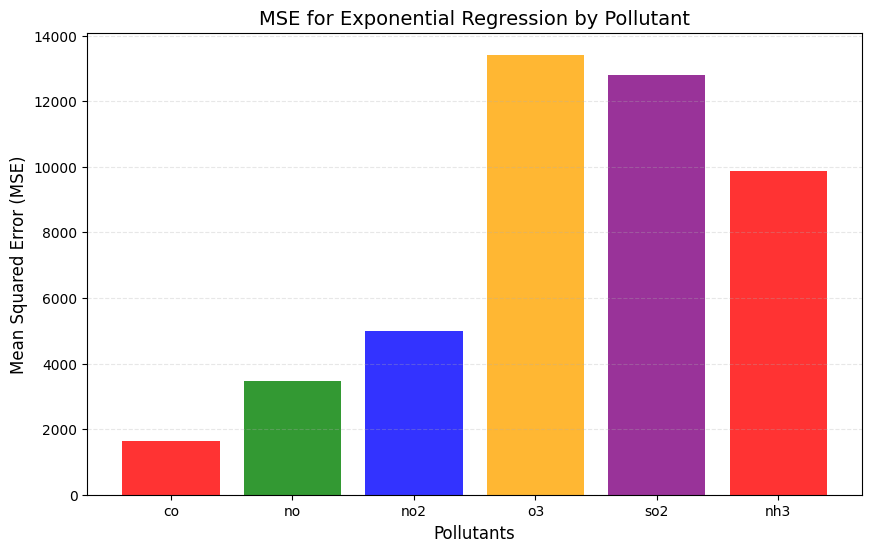

In [88]:
# Calculate and display MSE
exp_model.calculate_mse()


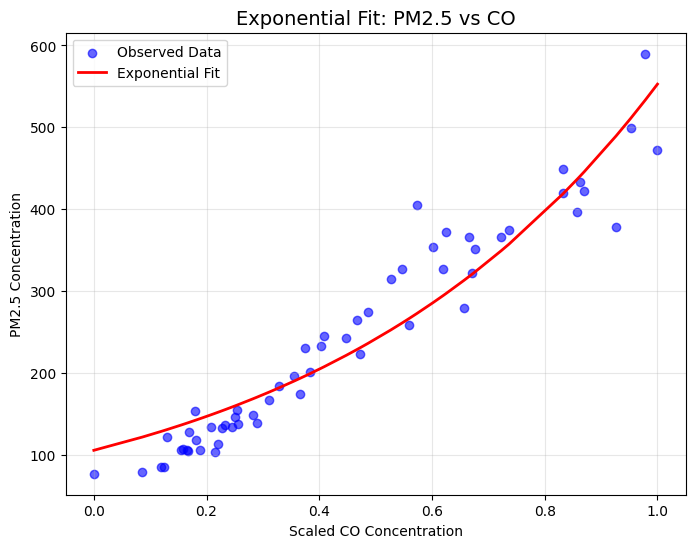

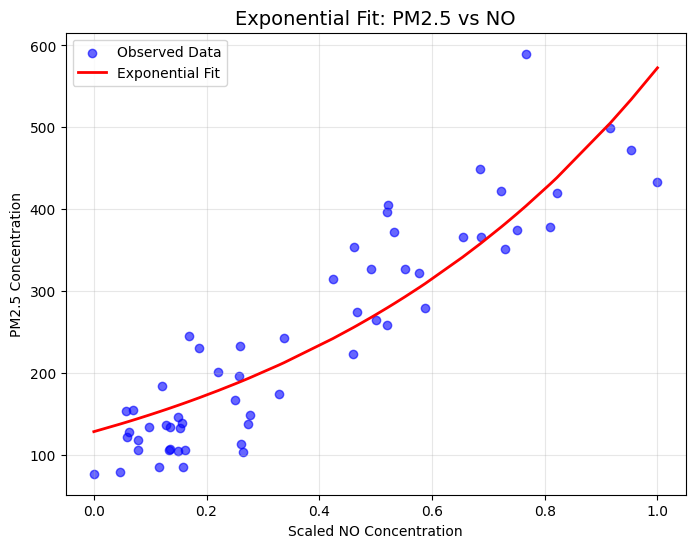

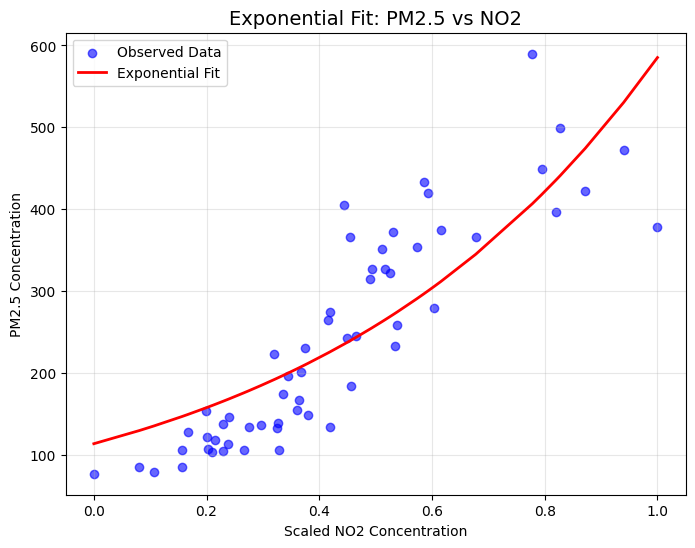

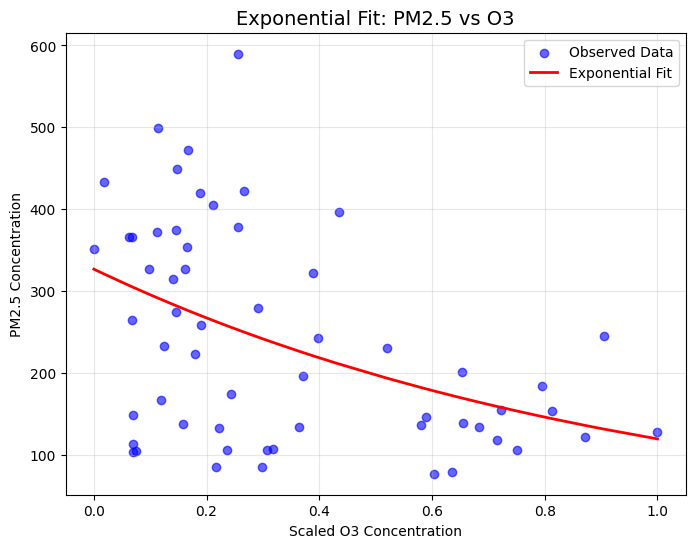

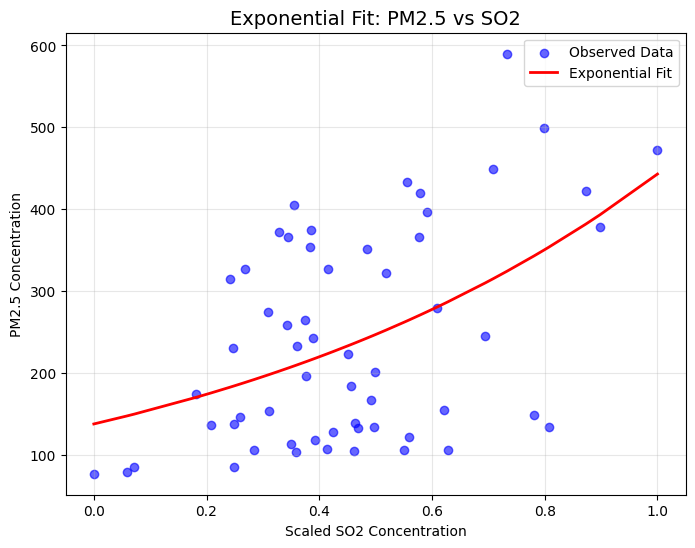

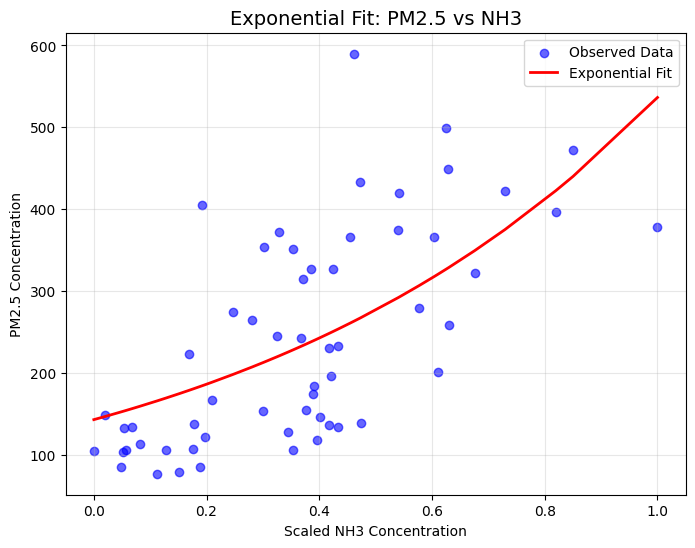

In [78]:
# Plot scatter plots and fit lines
exp_model.plot_fits()


/opt/anaconda3/envs/my-env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


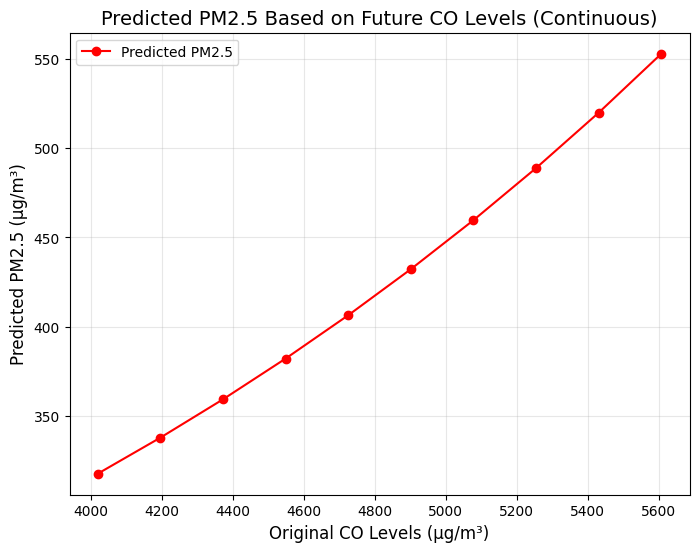

Future CO (original): 4019.39 µg/m³, Predicted PM2.5: 317.94 µg/m³
Future CO (original): 4195.83 µg/m³, Predicted PM2.5: 338.09 µg/m³
Future CO (original): 4372.26 µg/m³, Predicted PM2.5: 359.51 µg/m³
Future CO (original): 4548.70 µg/m³, Predicted PM2.5: 382.29 µg/m³
Future CO (original): 4725.13 µg/m³, Predicted PM2.5: 406.52 µg/m³
Future CO (original): 4901.57 µg/m³, Predicted PM2.5: 432.28 µg/m³
Future CO (original): 5078.00 µg/m³, Predicted PM2.5: 459.67 µg/m³
Future CO (original): 5254.44 µg/m³, Predicted PM2.5: 488.80 µg/m³
Future CO (original): 5430.87 µg/m³, Predicted PM2.5: 519.77 µg/m³
Future CO (original): 5607.31 µg/m³, Predicted PM2.5: 552.71 µg/m³


In [89]:
exp_model.prediction()

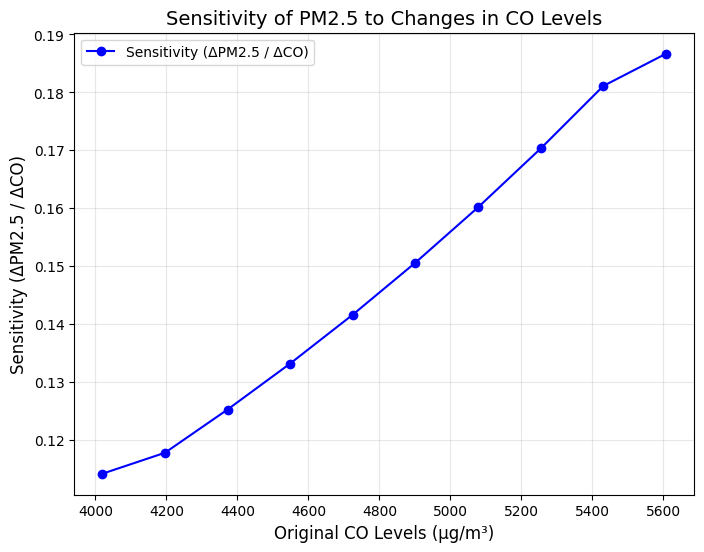

CO (original): 4019.39 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.11
CO (original): 4195.83 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.12
CO (original): 4372.26 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.13
CO (original): 4548.70 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.13
CO (original): 4725.13 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.14
CO (original): 4901.57 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.15
CO (original): 5078.00 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.16
CO (original): 5254.44 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.17
CO (original): 5430.87 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.18
CO (original): 5607.31 µg/m³, Sensitivity (ΔPM2.5 / ΔCO): 0.19


In [90]:
exp_model.sensitivity()

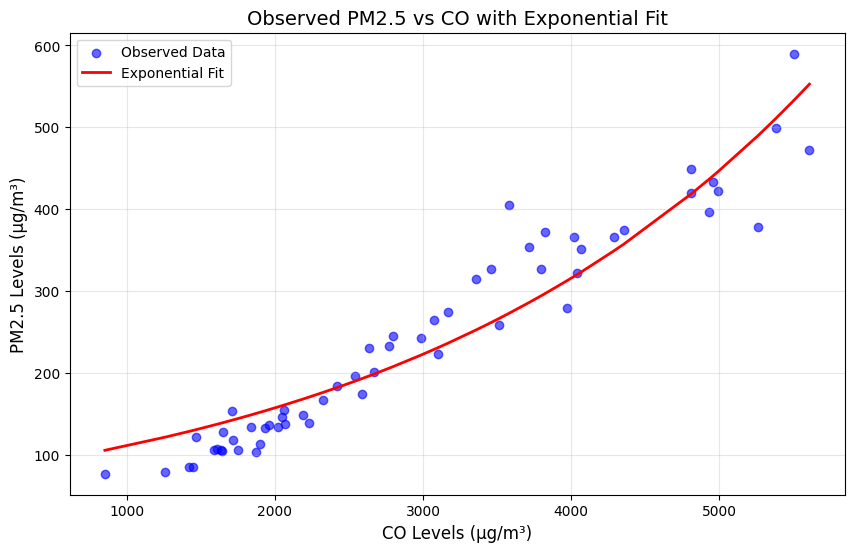

In [79]:
exp_model.overlay_prediction()